In [1]:
import torch
import torch.nn as nn
import torchvision  
from torchvision import datasets, transforms
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F  
import torch.optim as optim
import cv2

import random
import numpy as np
import os
from pathlib import Path
from tqdm import tqdm

In [2]:
# Define transformations (rescale = normalize in PyTorch)
transform = transforms.Compose([
    transforms.Grayscale(),                # Ensure grayscale (1 channel)
    #transforms.Resize((96, 96)),    
    transforms.Resize((48,48)),       # Resize images
    transforms.ToTensor(),                 # Converts to [0,1] float tensor
    transforms.Normalize((0.5,), (0.5,))   # Optional: normalize to [-1,1]
])

batch_size = 128

# Load training dataset
train_dataset = datasets.ImageFolder(
    root='/Users/madswolff/Downloads/asl_alphabet_train',
    transform=transform
)

# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

#laod test dataset
test_dataset = datasets.ImageFolder(
    root='/Users/madswolff/Downloads/asl_alphabet_test',
    transform=transform
)

# Create DataLoaders
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True
)

# Class names (if you want them)
train_class_names = train_dataset.classes
test_class_names = test_dataset.classes

In [3]:
train_dataset, test_dataset

(Dataset ImageFolder
     Number of datapoints: 78000
     Root location: /Users/madswolff/Downloads/asl_alphabet_train
     StandardTransform
 Transform: Compose(
                Grayscale(num_output_channels=1)
                Resize(size=(48, 48), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normalize(mean=(0.5,), std=(0.5,))
            ),
 Dataset ImageFolder
     Number of datapoints: 1815
     Root location: /Users/madswolff/Downloads/asl_alphabet_test
     StandardTransform
 Transform: Compose(
                Grayscale(num_output_channels=1)
                Resize(size=(48, 48), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normalize(mean=(0.5,), std=(0.5,))
            ))

In [4]:
'''class ASL_CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Define the convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Input 1 channel, output 32 channels
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # Input 32 channels, output 64 channels
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # Input 64 channels, output 128 channels
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # Input 128 channels, output 128 channels
        self.pool = nn.MaxPool2d(kernel_size=2)  # 2x2 Max pooling
        self.relu = nn.ReLU()  # ReLU activation
        
        # Flatten layer to convert 2D image data into 1D feature vector
        self.flatten = nn.Flatten()

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 6 * 6, 512)  # Adjusted input size after feature maps from conv layers
        self.fc2 = nn.Linear(512, 26)  # Output layer for 26 classes (ASL alphabet)

    def forward(self, x):
        # Apply convolutional layers with ReLU activation and pooling
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))  # Fourth convolution and pooling layer

        # Flatten the feature maps into a 1D vector
        x = self.flatten(x)

        # Apply fully connected layers
        x = self.relu(self.fc1(x))
        x = self.fc2(x)  # Output layer for classification

        return x'''

'class ASL_CNN(nn.Module):\n    def __init__(self):\n        super().__init__()\n\n        # Define the convolutional layers\n        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Input 1 channel, output 32 channels\n        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # Input 32 channels, output 64 channels\n        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # Input 64 channels, output 128 channels\n        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # Input 128 channels, output 128 channels\n        self.pool = nn.MaxPool2d(kernel_size=2)  # 2x2 Max pooling\n        self.relu = nn.ReLU()  # ReLU activation\n        \n        # Flatten layer to convert 2D image data into 1D feature vector\n        self.flatten = nn.Flatten()\n\n        # Fully connected layers\n        self.fc1 = nn.Linear(128 * 6 * 6, 512)  # Adjusted input size after feature maps from conv layers\n        self.fc2 = nn.Linear(512, 26)  # Output layer for 26 clas

In [5]:
class ASL_CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Define the convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Input 1 channel, output 32 channels
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # Input 32 channels, output 64 channels
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # Input 64 channels, output 128 channels
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # Input 128 channels, output 128 channels
        self.pool = nn.MaxPool2d(kernel_size=2)  # 2x2 Max pooling
        self.relu = nn.ReLU()  # ReLU activation
        
        # Flatten layer to convert 2D image data into 1D feature vector
        self.flatten = nn.Flatten()

        # Fully connected layers
        # Adjusted input size after feature maps from conv layers
        self.fc1 = nn.Linear(128 * 3 * 3, 512)  # Adjusted for the new size (128 channels * 3x3 feature map)
        self.fc2 = nn.Linear(512, 26)  # Output layer for 26 classes (ASL alphabet)

    def forward(self, x):
        # Apply convolutional layers with ReLU activation and pooling
        x = self.pool(self.relu(self.conv1(x)))  # 48x48 -> 24x24
        x = self.pool(self.relu(self.conv2(x)))  # 24x24 -> 12x12
        x = self.pool(self.relu(self.conv3(x)))  # 12x12 -> 6x6
        x = self.pool(self.relu(self.conv4(x)))  # 6x6 -> 3x3

        # Flatten the feature maps into a 1D vector
        x = self.flatten(x)

        # Apply fully connected layers
        x = self.relu(self.fc1(x))
        x = self.fc2(x)  # Output layer for classification

        return x

In [87]:
model = ASL_CNN()
print(model)

ASL_CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1152, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=26, bias=True)
)


In [ ]:
'''device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ASL_CNN().to(device)'''

In [ ]:
'''# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 5  # We will run for 5 epochs
model.train()  # Set model to training mode

for epoch in range(EPOCHS):
    running_loss = 0.0  # Initialize running loss for this epoch

    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{EPOCHS}"):
        images, labels = batch  # Unpack images and labels

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)  # Pass images through the model

        # Compute the loss
        loss = criterion(outputs, labels)

        # Update the running loss
        running_loss += loss.item()

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

    # Print average loss for the epoch
    print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {running_loss / len(train_loader):.4f}")'''

Epoch 1/5: 100%|██████████| 610/610 [30:47<00:00,  3.03s/it]    


Epoch 1/5, Loss: 0.8351


Epoch 2/5: 100%|██████████| 610/610 [03:38<00:00,  2.79it/s]


Epoch 2/5, Loss: 0.1177


Epoch 3/5: 100%|██████████| 610/610 [03:35<00:00,  2.83it/s]


Epoch 3/5, Loss: 0.0622


Epoch 4/5: 100%|██████████| 610/610 [03:39<00:00,  2.78it/s]


Epoch 4/5, Loss: 0.0422


Epoch 5/5: 100%|██████████| 610/610 [03:33<00:00,  2.86it/s]

Epoch 5/5, Loss: 0.0312


In [ ]:
'''# Set model to evaluation mode
model.eval()

# Lists to store true and predicted labels
y_true = []
y_pred = []

# Disable gradient calculation during evaluation (for efficiency)
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        images, labels = batch
        
        # Forward pass through the model
        outputs = model(images)  
        
        # Get the predicted class by selecting the index with the highest score
        predictions = torch.argmax(outputs, dim=1)

        # Store the true and predicted labels
        y_true.extend(labels.cpu().numpy())  # Move to CPU and convert to numpy array
        y_pred.extend(predictions.cpu().numpy())  # Move to CPU and convert to numpy array

# Print the classification report
target_names = [chr(i) for i in range(65, 91)]  # ASL alphabet 'A' to 'Z'

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))'''

Testing: 100%|██████████| 15/15 [00:02<00:00,  7.05it/s]


Classification Report:
              precision    recall  f1-score   support

           A       0.00      0.00      0.00        70
           B       0.00      0.00      0.00        70
           C       0.00      0.00      0.00        70
           D       0.00      0.00      0.00        70
           E       0.07      0.71      0.13        70
           F       0.00      0.00      0.00        70
           G       0.03      0.09      0.05        70
           H       0.00      0.00      0.00        70
           I       0.00      0.00      0.00        70
           J       0.00      0.00      0.00        70
           K       0.00      0.00      0.00        70
           L       0.00      0.00      0.00        70
           M       0.05      0.03      0.04        70
           N       0.00      0.00      0.00        70
           O       0.00      0.00      0.00        70
           P       0.00      0.00      0.00        70
           Q       0.00      0.00      0.00        70
   


/Users/madswolff/anaconda3/envs/aiml25-ma1/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/madswolff/anaconda3/envs/aiml25-ma1/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/madswolff/anaconda3/envs/aiml25-ma1/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

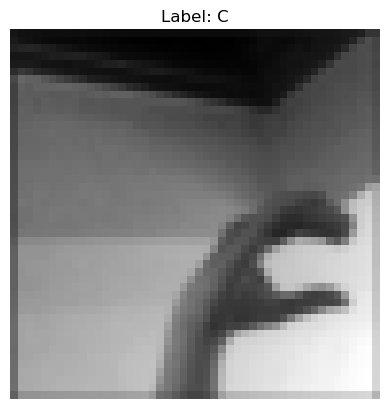

In [ ]:
'''import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images and labels
images, labels = next(iter(train_loader))

# Take the first image in the batch
image = images[0]

# Reverse the normalization (optional, if you want to see the image in original scale)
image = image / 2 + 0.5  # Unnormalize if you used Normalize((0.5,), (0.5,))

# Convert tensor to numpy for visualization
image = image.numpy().squeeze()  # Squeeze to remove extra dimension for grayscale

# Display the image
plt.imshow(image, cmap='gray')
plt.title(f'Label: {train_class_names[labels[0]]}')
plt.axis('off')  # Hide axes for clarity
plt.show()
'''

CAMERA STUFF

In [ ]:
'''torch.save(model.state_dict(), 'asl_cnn_weights.pth')'''

In [6]:
# Load model and weights
model = ASL_CNN()
model.load_state_dict(torch.load('asl_cnn_weights.pth', map_location='cpu'))
model.eval()

# Define image transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Define class labels (you can load from train_dataset.classes if available)
labels = [chr(i) for i in range(65, 91)]  # A-Z

# Open webcam
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Could not open video stream.")
else:
    print("Webcam is open, ready to capture.")

while True:
    ret, frame = cap.read()
    
    if not ret:
        print("Error: Failed to capture image.")
        break

    # Mirror the frame (horizontal flip)
    frame = cv2.flip(frame, 1)

    # Increase the size of the square
    h, w = frame.shape[:2]
    box_size = 700  # Make the square 500px instead of 300px
    top_left = (w // 2 - box_size // 2, h // 2 - box_size // 2)
    bottom_right = (top_left[0] + box_size, top_left[1] + box_size)

    # Draw rectangle
    cv2.rectangle(frame, top_left, bottom_right, (0, 0, 255), 2)

    # Get ROI
    roi = frame[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]
    if roi.shape[0] == 0 or roi.shape[1] == 0:
        continue

    # Preprocess ROI
    try:
        img_tensor = transform(roi).unsqueeze(0)  # Add batch dimension

        # Predict
        with torch.no_grad():
            output = model(img_tensor)
            pred_idx = output.argmax().item()
            confidence = torch.softmax(output, dim=1)[0, pred_idx].item() * 100
            predicted_label = labels[pred_idx]

        # Display prediction
        msg = f"{predicted_label}, Conf: {confidence:.1f}%"
        cv2.putText(frame, msg, (top_left[0], top_left[1] - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2)
    except Exception as e:
        print(f"Error during prediction: {e}")

    # Show the frame with the rectangle and prediction
    cv2.imshow("ASL Live Prediction", frame)

    # Check if 'q' is pressed to break loop
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):  # If 'q' is pressed, exit the loop
        print("Exiting...")
        break

# Cleanup: release the camera and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()

/var/folders/1q/snl996k91jzb97fx3w_zmck40000gn/T/ipykernel_36025/193514495.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('asl_cnn_weig

Webcam is open, ready to capture.


2025-04-10 15:54:38.089 python[36025:1439318] +[IMKClient subclass]: chose IMKClient_Modern
2025-04-10 15:54:38.089 python[36025:1439318] +[IMKInputSession subclass]: chose IMKInputSession_Modern


Exiting...
